# MAE6592 Python Assignment: Part I

By Intelligent System Lab, University of Virginia


## 1. Preparation

Prepare the environment for production line simulation.

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#### This script leverages three existing packages

    1. numpy:  scientific calculations
        Documentation: https://numpy.org/doc/stable/
    2. pandas: data management
        Documentation: https://pandas.pydata.org/docs/
    3. matplotlib.pyplot: plotting
        Documentation: https://matplotlib.org/api/pyplot_api.html

The below codes construct a python 'class' for the serial production line.

In [17]:
class serial_line:
    def __init__(self, cycle_time, buffer_capacity, buffer_initial=-1):
        """
        Arguments:
            cycle_time: the cycle time of each machine in minute, list or numpy array
            buffer_capacity: the maximum capacity of each buffer, list or numpy array
            buffer_initial: the initial buffer level of each buffer, zeros by default, list or numpy array

        """
        self.M = len(cycle_time)                #length of the serial line
        self.ct = cycle_time                    #cycle time
        self.bc = buffer_capacity               #buffer capacity
        self.slowest = np.argmax(self.ct)       #find the slowest machine

        if buffer_initial == -1:
            self.bi = np.zeros(self.M - 1)        #if initial buffer levels are not specified, start from zero
        else:
            self.bi = np.array(buffer_initial)  #initial buffer level

        """calculate buffer boundary"""
        self.beta = np.zeros((self.M, self.M))
        for i in range(self.M):
            for j in range(self.M):
                self.beta[i, j] = (sum(self.bc[i:j]) - sum(self.bi[i:j]))\
                *(i < j) + sum(self.bi[j:i]) * (i > j)

    def run(self, T, downtime, decimal=0):
        """
        Arguments:
            T: the total simulation time length in minute, int
            downtime: the downtime/ow you want to insert, tuple or list
                      ([[1st_timeofow,1st_durationofow],[2nd_timeofow,2nd_durationofow]]     #machine 1
                      [],                                                                    #machine 2, blank list if no ow inserted
                      ...,                                                                   #...
                      [[1st_timeofow,1st_durationofow]])                                     #machine M
            decimal: the decimals in the simulation time horizon, zero by default, int
        Return:
            stepwise buffer levels
            stepwise production counts
        """
        tpoints = T * (10**decimal) + 1

        b = np.zeros((self.M-1, tpoints))         #buffer level
        b[:,0] = self.bi                         #initial buffer level
        pc = np.zeros((self.M, tpoints))          #production counts

        self.w = np.zeros((self.M, tpoints))      #generate downtime list according to downtime input
        for i in range(self.M):
            for j in downtime[i]:
                self.w[i, int(np.round(j[0]*(10**decimal))):\
                       int(np.round((j[0]+j[1])*(10**decimal)))] = 1         #w=1 if the machine is down at the time step

        for t in range(1,tpoints):
            pc[:,t] = pc[:, t-1] + (1 - self.w[:, t-1]) / self.ct / (10**decimal)
            for i in range(self.M):
                temp = self.beta[i, :] + pc[:, t]
                pc[i, t] = np.min(temp)
            b[:, t] = pc[:self.M-1, t] - pc[1:, t] + self.bi                          #calculate buffer levels

        time = np.round(np.linspace(0, T, tpoints), decimals=decimal)             #generate time steps
        self.b = pd.DataFrame(b.T,
                              index=time,
                              columns=["B" + str(x) for x in range(2, self.M+1)]) #store results to pandas dataframe
        self.b = self.b.round(np.max((6, decimal)))                             #round results to remove numerical errors

        self.pc = pd.DataFrame(pc.T,
                               index=time,
                               columns=["M" + str(x) for x in range(1, self.M+1)])
        self.pc = self.pc.round(np.max((6, decimal)))

        return self.b, self.pc

## 2. Parameter Setting

Follow the steps to set your parameters.

In [18]:
"""Input parameters for assignment 1"""

"""Input cylce time (minunte)"""
cycle_time = [1/5,
              1/2,
              1/4,
              1/3]

"""Input maximum buffer capacities (parts)"""
buffer_capacity = [100,
                   200,
                   200]

"""Input initial buffer levels (parts)"""
buffer_initial = [50,
                  100,
                  100]

"""Input opportunity windows"""
tow1 = 0
pow1 = 1

"""Input simulation time length (minute)"""
T = 8 * 60

#### *In assignment 1, you are not required to change the codes below this line.*
===============================================================================

## 3. Execution

With the parameters given in previous section, the simulation is excetuted in this cell.

In [19]:
downtime=([[100, tow1*pow1]],
           [],
           [],
           [])

line1 = serial_line(cycle_time, buffer_capacity, buffer_initial)     #construct serial production line with the given parameters
b, pc = line1.run(T, downtime, decimal=2)                             #run the serial production line and get results


## 4. Result Interpretation

### Final Production Count

In [20]:
print("\nProduction Count of Machine 1 =", pc.M1.iloc[-1])             #index -1 points to the last element
print("Production Count of Machine 2 =", pc.M2.iloc[-1])
print("Production Count of Machine 3 =", pc.M3.iloc[-1])
print("Production Count of Machine 4 =", pc.M4.iloc[-1],"\n")


Production Count of Machine 1 = 1010.0
Production Count of Machine 2 = 960.0
Production Count of Machine 3 = 1060.0
Production Count of Machine 4 = 1160.0 



### Buffer Level

In [21]:
print("\nBuffer Level of Buffer 2 at t = 100 mins =", b.B2[100])
print("Buffer Level of Buffer 3 at t = 100 mins =", b.B3[100])
print("Buffer Level of Buffer 4 at t = 100 mins =", b.B4[100], "\n")


Buffer Level of Buffer 2 at t = 100 mins = 100.0
Buffer Level of Buffer 3 at t = 100 mins = -0.0
Buffer Level of Buffer 4 at t = 100 mins = 100.0 



### Visualization

In [22]:
if pow1 == 1 and tow1 == 0:
    filenum = "1"
elif pow1 == 1 and tow1 != 0:
    filenum = "2"
elif pow1 == 2 and tow1!=0:
    filenum = "3"

<Figure size 640x480 with 0 Axes>

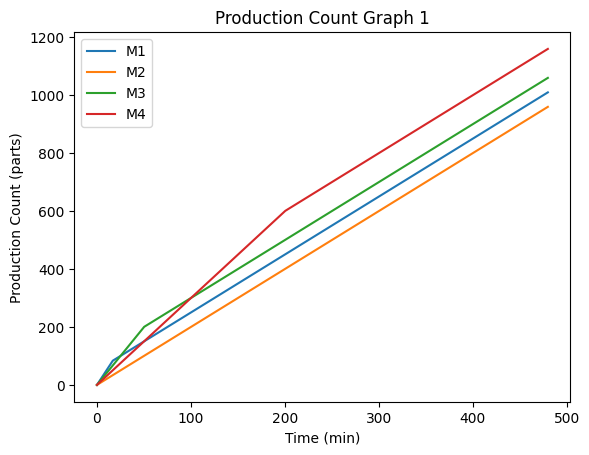

In [25]:
plt.figure()
pc.plot()
plt.ylabel("Production Count (parts)")
plt.xlabel("Time (min)")
plt.title("Production Count Graph {}".format(filenum))
plt.savefig("PC{}.png".format(filenum), dpi=500)
plt.show()

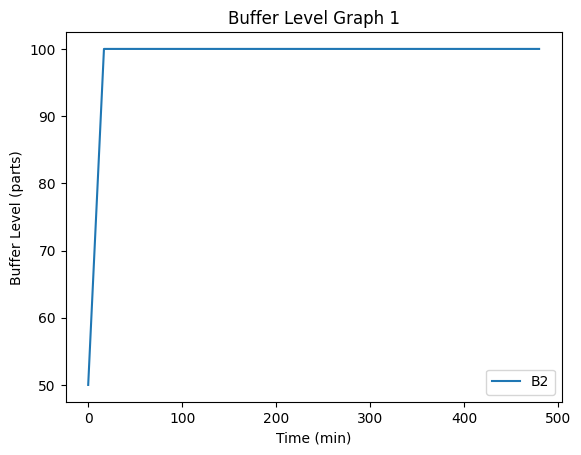

In [24]:
plt.figure()
b.B2.plot()
plt.legend(["B2"])
plt.ylabel("Buffer Level (parts)")
plt.xlabel("Time (min)")
plt.title("Buffer Level Graph {}".format(filenum))
plt.savefig("BL{}.png".format(filenum), dpi=500)
plt.show()